# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in IDR data

## 1.1 - Load in IDR data for clusters derived from all IDRs ≥ 30

In [2]:
thumandf=pd.read_excel('data/Test_all_idrs_clust_30_all_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(thumandf.isnull().any())
thumandf = thumandf.fillna('')

thumandf=thumandf[thumandf['IDR Length']>=0]

tfullaccs=thumandf['Uniprot'].tolist()
tfullaccswnums=thumandf['Uniprot w IDRnum'].tolist()
tfullgeneswnums=thumandf['Gene'].tolist()
tfullclusternum=thumandf['Cluster Number'].tolist()
tfullseqlens=thumandf['IDR Length'].tolist()
tfullstpos=thumandf['Start Pos'].tolist()
tfullenpos=thumandf['End Pos'].tolist()
tfullproteinlength=thumandf['Full Protein Length'].tolist()
tfullmininterclustdist=thumandf['Min Inter Clust Dist'].tolist()
tfulltermini=thumandf['IDR Position'].tolist()
tfulllocationbyunistring=thumandf['HPA Location'].tolist()
tfullseqs=thumandf['Sequence'].tolist()

print(thumandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              14   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1               9   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2              11   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              14   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4               5   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in data for clusters derived from IDRs of length 100 ≤ n ≤ 300

In [3]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')
humandf=humandf[humandf['IDR Length']>=0]

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

# Part 2: Analyze minimum inter cluster distances

       Min Inter Clust Dist K Means Type Length Range
0                  8.592811   100 to 300        30-99
1                 14.569964   100 to 300        30-99
2                  4.777867   100 to 300        30-99
3                  0.753103   100 to 300        30-99
4                  3.491170   100 to 300        30-99
...                     ...          ...          ...
49011             17.292741          All      100-300
49012             10.098410          All        30-99
49013              7.180470          All        30-99
49014              2.987906          All        30-99
49015              1.632500          All        30-99

[49016 rows x 3 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100-300_100 to 300 v.s. 100-300_All: t-test paired samples with Bonferroni correction, P_val=9.393e-11 stat=6.657e+00
30-99_100 to 300 v.s. 30-99_All: t-test pair

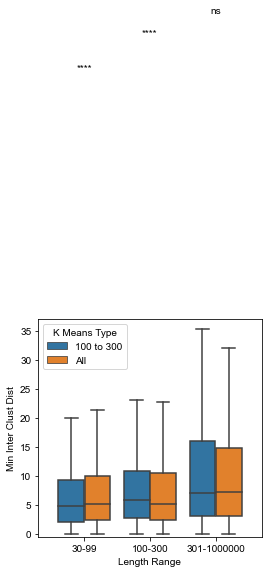

In [5]:
plt.figure(figsize=(4,4))
#strange=[30, 60, 90, 120, 150, 180, 210]
#enrange=[59, 89, 119, 149, 179, 209, 10000000]
strange=[30, 100, 301]
enrange=[99, 300, 1000000]
myrangename=[]
for i in range(0,len(strange)):
    myrangename.append(str(strange[i])+'-'+str(enrange[i]))
    
mindistlist=[]
whichkmeans=[]
whichlenrange=[]
for i in range(0,len(fullmininterclustdist)):
    mindistlist.append(fullmininterclustdist[i])
    whichkmeans.append('100 to 300')
    for j in range(0,len(strange)):
        if fullseqlens[i]>=strange[j] and fullseqlens[i]<=enrange[j]:
            whichlenrange.append(myrangename[j])
            
for i in range(0,len(tfullmininterclustdist)):
    mindistlist.append(tfullmininterclustdist[i])
    whichkmeans.append('All')
    for j in range(0,len(strange)):
        if tfullseqlens[i]>=strange[j] and tfullseqlens[i]<=enrange[j]:
            whichlenrange.append(myrangename[j])
    
mindistdf=pd.DataFrame()
mindistdf['Min Inter Clust Dist']=mindistlist
mindistdf['K Means Type']=whichkmeans
mindistdf['Length Range']=whichlenrange
print(mindistdf)
ax=sbn.boxplot(data=mindistdf,x="Length Range",y="Min Inter Clust Dist",hue="K Means Type",showfliers=False,order=myrangename)
from statannot import add_stat_annotation

add_stat_annotation(ax, data=mindistdf, x="Length Range",y="Min Inter Clust Dist",hue="K Means Type", order=myrangename,
                    box_pairs=[((myrangename[0],'100 to 300'), (myrangename[0],'All')),((myrangename[1],'100 to 300'), (myrangename[1],'All')),((myrangename[2],'100 to 300'), (myrangename[2],'All'))],
                    test='t-test_paired', text_format='star', loc='inside', verbose=2)
ax.set_ylim([-0.5, 37])
#t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal

#plt.savefig('Test_all_idrs_clust_30_vs_100_300_clust_30_min_inter_clust_dist.pdf', transparent=True, bbox_inches = "tight") 

#with pd.ExcelWriter('../Supplementary_Tables/Table_S1.xlsx', engine='openpyxl',mode='a') as writer:
#    mindistdf.to_excel(writer,sheet_name='Fig_S1D')